In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
import cython
%load_ext Cython

In [3]:
%%cython
#cython: boundscheck=False, wraparound=False, initializedcheck=False, nonecheck=False, cdivision=True
import cython
import numpy as np
cimport numpy as np
np.import_array()

from libc.math cimport round, sqrt


DOUBLE = np.float64
ctypedef np.float64_t DOUBLE_t
INTEGER = np.int32


cdef class LJBox:
    cdef double epsilon, sigma
    cdef double r_cut, r_cut2
    cdef double e_cut
    cdef double r_skin, r_skin2
    cdef int n_part, n_dim
    cdef double[:] box_shape
    
    cdef double[:] rij
    cdef int[:] list_near
    cdef int[:] iarr_part
    cdef double[:, ::1] pos_start
    cdef public int n_update
    
    def __init__(self, double epsilon, double sigma,
                 double r_cut, double r_skin,
                 int n_dim, double[:] box_shape, int n_part):
        self.epsilon, self.sigma = epsilon, sigma
        self.r_cut, self.r_skin = r_cut, r_skin
        self.r_cut2 = self.r_cut * self.r_cut
        self.r_skin2 = self.r_skin * self.r_skin
        self.n_update = 0
        
        self.n_dim, self.n_part = n_dim, n_part
        self.box_shape = np.array(box_shape, dtype=DOUBLE)
        
        self.rij = np.zeros(n_dim, dtype=DOUBLE)
        
        self.list_near = np.zeros((n_part - 1) * n_part / 2, dtype=INTEGER)
        self.iarr_part = np.zeros(n_part, dtype=INTEGER)
        self.pos_start = np.zeros((n_part, n_dim), dtype=DOUBLE)
        
        cdef double r2, r6
        r2 = self.r_cut2 / (sigma * sigma)
        r6 = r2 * r2 * r2
        self.e_cut = 4 * epsilon * (1 / (r6 * r6) - 1 / r6)
        
    cdef void compute_neighbours(self, double [:, ::1] pos):
        self.n_update += 1
        cdef int iarr, i_part, j_part, i_dim
        cdef double dr2, delta
        self.list_near[...] = 0
        self.iarr_part[...] = 0
        
        for i_part in range(self.n_part):
            for i_dim in range(self.n_dim):
                self.pos_start[i_part, i_dim] = pos[i_part, i_dim]
        
        iarr = 0
        for i_part in range(self.n_part - 1):
            self.iarr_part[i_part] = iarr
            for j_part in range(i_part + 1, self.n_part):
                dr2 = 0
                for i_dim in range(self.n_dim):
                    delta = pos[j_part, i_dim] - pos[i_part, i_dim]
                    delta -= self.box_shape[i_dim] * round(delta / self.box_shape[i_dim])
                    
                    dr2 += delta * delta
                
                if dr2 < self.r_skin2:
                    self.list_near[iarr] = j_part
                    iarr += 1
        self.iarr_part[self.n_part-1] = iarr

        
    cpdef double compute_force_en(self, double[:] rij, double[:] fi, double[:] fj):
        cdef double r2, r6, r12, fac
        cdef int i_dim
        
        r2 = 0
        for i_dim in range(self.n_dim):
            r2 += rij[i_dim] * rij[i_dim]
        
        if r2 > self.r_cut2:
            return 0
        r2 /= self.sigma * self.sigma
        
        r6 = r2 * r2 * r2
        r12 = r6 * r6
        fac = 48 * (1 / r12 - 0.5 / r6) / r2

        fac *= self.epsilon / self.sigma
        
        for i_dim in range(self.n_dim):
            fi[i_dim] -= fac * rij[i_dim]
            fj[i_dim] += fac * rij[i_dim]
        
        fac = 4 * (1 / r12 - 1 / r6)
        fac *= self.epsilon

        return fac - self.e_cut
        
    cdef double compute(self, double[:, ::1] pos, double[:, ::1] force):
        cdef int i_part, j_part, i_dim, iarr
        cdef double delta, dr, dr1, dr2
        cdef double e_pot

        e_pot = 0
        
        dr1, dr2 = 0, 0
        for i_part in range(self.n_part):
            dr = 0
            for i_dim in range(self.n_dim):
                delta = pos[i_part, i_dim] - self.pos_start[i_part, i_dim]
                dr += delta * delta
            dr = sqrt(dr)
            if dr > dr1:
                dr2 = dr1
                dr1 = dr
            elif dr > dr2:
                dr2 = dr
        
        if dr1 + dr2 >= self.r_skin - self.r_cut:
            self.compute_neighbours(pos)
        
        for i_part in range(self.n_part - 1):
            for iarr in range(self.iarr_part[i_part], self.iarr_part[i_part + 1]):
                j_part = self.list_near[iarr]
                
                for i_dim in range(self.n_dim):
                    delta = pos[j_part, i_dim] - pos[i_part, i_dim]
                    self.rij[i_dim] = delta - self.box_shape[i_dim] * round(delta / self.box_shape[i_dim])
                
                e_pot += self.compute_force_en(self.rij, force[i_part, :],
                                              force[j_part, :])
        
        return e_pot


cdef class IntVerletLJ:
    cdef double del_t
    cdef int n_part, n_dim
    cdef double[:, ::1] force
    cdef double[:] box_shape
    cdef LJBox lj
    
    cdef bint enable_langevin
    cdef double kbT, gamma
    
    def __init__(self, int n_part, int n_dim, double[:] box_shape,
                 double del_t, LJBox lj, double kbT=0,
                 bint enable_langevin=0, double gamma=0):
        self.n_part, self.n_dim = n_part, n_dim
        self.box_shape = box_shape
        self.del_t = del_t
        self.lj = lj

        self.force = np.zeros((n_part, n_dim), dtype=DOUBLE)
        
        self.enable_langevin = enable_langevin
        self.kbT = kbT
        self.gamma = gamma
        
    cdef double compute_force(self, double[:, ::1] pos):
        cdef double e_pot = 0
        self.force[...] = 0
        
        e_pot += self.lj.compute(pos, self.force)
        
        return e_pot
        
    def step(self, double[:] mass, double[:, ::1] pos_t, double[:, ::1] vel_t,
             double[:, ::1] pos_n, double[:, ::1] vel_n):
        cdef double e_pot, e_kin
        
        e_pot, e_kin = 0, 0
        
        self.compute_force(pos_t)
        
        cdef double[:, :] xi_arr, eta_arr
        cdef double xi, eta
        cdef double sigma
        if self.enable_langevin:
            xi_arr = np.random.normal(loc=0, scale=1.0, size=(self.n_part, self.n_dim))
            eta_arr = np.random.normal(loc=0, scale=1.0, size=(self.n_part, self.n_dim))
        cdef double sq_dt = sqrt(self.del_t)
        cdef double _1bysq3 = sqrt(1./3)
        
        
        for i_part in range(self.n_part):
            for i_dim in range(self.n_dim):
                vel_n[i_part, i_dim] = vel_t[i_part, i_dim] \
                                     + 0.5 * self.del_t * self.force[i_part, i_dim] / mass[i_part]
                if self.enable_langevin:
                    sigma = sqrt(2 * self.kbT * self.gamma * mass[i_part])
                    xi = xi_arr[i_part, i_dim]
                    eta = eta_arr[i_part, i_dim]
                    vel_n[i_part, i_dim] += (- 0.5 * self.del_t * self.gamma * vel_t[i_part, i_dim]
                                             + 0.5 * sq_dt * sigma * xi
                                             - 0.125 * self.del_t * self.del_t * self.gamma \
                                                     * (self.force[i_part, i_dim] / mass[i_part] - self.gamma * vel_t[i_part, i_dim])
                                             - 0.25 * self.del_t * sq_dt * self.gamma * sigma * (0.5 * xi + _1bysq3 * eta))
                
                pos_n[i_part, i_dim] = pos_t[i_part, i_dim] + self.del_t * vel_n[i_part, i_dim]
                if self.enable_langevin:
                    pos_n[i_part, i_dim] += 0.5 * _1bysq3 * self.del_t * sq_dt * sigma * eta
                
                pos_n[i_part, i_dim] = pos_n[i_part, i_dim] % self.box_shape[i_dim]
                if pos_n[i_part, i_dim] < 0:
                    pos_n[i_part, i_dim] += self.box_shape[i_dim]
        
        e_pot = self.compute_force(pos_n)
        
        cdef double vel_h
        for i_part in range(self.n_part):
            for i_dim in range(self.n_dim):
                vel_h = vel_n[i_part, i_dim]
                vel_n[i_part, i_dim] += 0.5 * self.del_t * self.force[i_part, i_dim] / mass[i_part]
                if self.enable_langevin:
                    sigma = sqrt(2 * self.kbT * self.gamma * mass[i_part])
                    xi = xi_arr[i_part, i_dim]
                    eta = eta_arr[i_part, i_dim]
                    vel_n[i_part, i_dim] += (- 0.5 * self.del_t * self.gamma * vel_h
                                             + 0.5 * sq_dt * sigma * xi
                                             - 0.125 * self.del_t * self.del_t * self.gamma \
                                                     * (self.force[i_part, i_dim] / mass[i_part] - self.gamma * vel_h)
                                             - 0.25 * self.del_t * sq_dt * self.gamma * sigma * (0.5 * xi + _1bysq3 * eta))
                
                e_kin += 0.5 * mass[i_part] * vel_n[i_part, i_dim] * vel_n[i_part, i_dim]
        
        if not self.enable_langevin:
            fac = np.sqrt(self.n_part * (self.kbT * self.n_dim / 2) / e_kin)
            for i_part in range(self.n_part):
                for i_dim in range(self.n_dim):
                    vel_n[i_part, i_dim] *= fac
        
                
        return e_pot, e_kin
        
        

In [4]:
epsilon, sigma, m = 1, 1, 1
r_cut = 4 * sigma
r_skin = 4.5 * sigma

n_dim = 3
n_part = 1

rho = 0.1 * sigma**3
del_t = 0.05 * np.sqrt((m * sigma**2) / epsilon)
n_step = 20000
kbT = 0.01 * epsilon
gamma = 1

mass = np.ones(n_part, dtype=np.float64) * m
a = 1000
print(a)
box_shape = np.ones(n_dim, dtype=np.float64) * a

pos = np.zeros((n_step+1, n_part, n_dim), dtype = np.float64)
vel = np.zeros((n_step+1, n_part, n_dim), dtype = np.float64)
ke = np.zeros(n_step+1, dtype=np.float64)
pe = np.zeros(n_step+1, dtype=np.float64)

pos[0] = np.ones((n_part, n_dim)) * 0.5 * box_shape
#pos[0], vel[0] = initialize_pos_vel(mass, box_shape, kbT)

lj = LJBox(epsilon, sigma, r_cut, r_skin, n_dim, box_shape, n_part)
verlet = IntVerletLJ(n_part, n_dim, box_shape, del_t, lj, kbT, True, gamma)


1000


In [5]:
%%time
for i in range(n_step):
    print('{:d} / {:d}; {:f}, {:f} {:f}'.format(i, n_step,
                                                ke[i], pe[i], ke[i] + pe[i]), end='\r')
    pe[i+1], ke[i+1] = verlet.step(mass, pos[i], vel[i], pos[i+1], vel[i+1])
print('done')
print(lj.n_update)

done9 / 20000; 0.001962, 0.000000 0.001962
158
CPU times: user 2.31 s, sys: 564 ms, total: 2.87 s
Wall time: 2.24 s


In [6]:
#print(pos)

(20001, 1, 3)


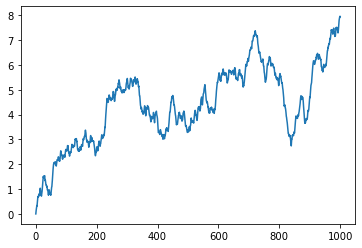

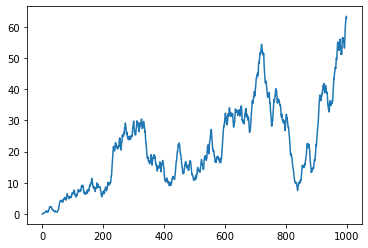

In [7]:
print(pos.shape)
t = del_t * np.arange(n_step+1)
r = np.linalg.norm(pos - pos[0], axis=2)
fig = plt.figure()
plt.plot(t, np.mean(r, axis=1))
plt.show()

r2 = r * r
r2_mean = np.mean(r2, axis=1)


fig = plt.figure()
plt.plot(t, r2_mean)
plt.show()

In [8]:
np.mean((r2_mean / t)[1000:])

/tmp/ipykernel_27863/236541763.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.mean((r2_mean / t)[1000:])


0.04765255917716141

In [9]:
from scipy.stats import maxwell

def initialize_pos_vel(mass, box_shape, e_temp):
    n_part = len(mass)
    n_dim = len(box_shape)
    coord_list = []
    n_mesh = np.ceil((n_part)**(1./n_dim))
    n_mesh = int(n_mesh)

    for i in range(n_dim):
        coord = np.linspace(0, box_shape[i], n_mesh + 1, endpoint=False)[1:]
        coord_list.append(coord)
    coords_mesh = np.array(np.meshgrid(*coord_list, indexing='xy')).reshape(n_dim, -1)
    pos_start = coords_mesh[:, :n_part]

    vel_start = np.zeros((n_part, n_dim), dtype=np.float64)
    for i in range(n_part):
        vel_start[i] = maxwell.rvs(size=n_dim, scale=np.sqrt(e_temp / (n_dim * mass[i])))
    vel_start[:] *= 2 * np.random.randint(2, size=(n_part, n_dim)) - 1

    print(np.mean(0.5 * mass.reshape(-1, 1) * np.sum(vel_start**2, axis=1)))
    print(np.mean(mass.reshape(-1, 1) * vel_start))
    print(np.sum(0.5 * mass.reshape(-1, 1) * vel_start**2))
    return pos_start.transpose(), vel_start

In [10]:
epsilon, sigma, m = 1, 1, 1
r_cut = 4 * sigma
r_skin = 4.5 * sigma

n_dim = 3
if n_dim == 3:
    n_part = 864
elif n_dim == 2:
    n_part = 10

rho = 0.1 * sigma**3
del_t = 0.002 * np.sqrt(epsilon / (m * sigma**2))
n_step = 20000
T = 6.0 * epsilon

mass = np.ones(n_part, dtype=np.float64) * m
a = (np.sum(mass) / rho)**(1./n_dim)
print(a)
box_shape = np.ones(n_dim, dtype=np.float64) * a


pos = np.zeros((n_step+1, n_part, n_dim), dtype = np.float64)
vel = np.zeros((n_step+1, n_part, n_dim), dtype = np.float64)
ke = np.zeros(n_step+1, dtype=np.float64)
pe = np.zeros(n_step+1, dtype=np.float64)

print(pos.shape, vel.shape)
pos[0], vel[0] = initialize_pos_vel(mass, box_shape, T)

lj = LJBox(epsilon, sigma, r_cut, r_skin, n_dim, box_shape, n_part)
verlet = IntVerletLJ(n_part, n_dim, box_shape, del_t, lj, T)


20.51971136012036
(20001, 864, 3) (20001, 864, 3)
9.226615202623023
-0.03605245551870569
7971.79553506629


In [11]:
# i = 0
# %prun ke[i+1], pe[i+1] = verlet.step(mass, pos[i], vel[i], pos[i+1], vel[i+1])

In [ ]:
%%time
for i in range(n_step):
    print('{:d} / {:d}; {:f}, {:f} {:f}'.format(i, n_step,
                                                ke[i], pe[i], ke[i] + pe[i]), end='\r')
    pe[i+1], ke[i+1] = verlet.step(mass, pos[i], vel[i], pos[i+1], vel[i+1])
print('done')
print(lj.n_update)

In [ ]:
fig = plt.figure()
plt.plot(ke)
plt.show()

fig = plt.figure()
plt.plot(pe)
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(pos[:, 0, 0])
plt.show()

In [ ]:
print(np.mean(ke[5000:]) / n_part)
print(np.mean(pe[5000:]) / n_part)

In [ ]:
# fig = plt.figure(figsize=(8,10))
# ax = fig.add_subplot(projection='3d')
# ax.set(xlim3d=(0, box_shape[0]), xlabel='X')
# ax.set(ylim3d=(0, box_shape[1]), ylabel='Y')
# ax.set(zlim3d=(0, box_shape[2]), zlabel='Z')

# t = 1000
# data = pos[t, :, :]
# ax.scatter(data[:, 0], data[:, 1], data[:, 2])

In [ ]:
%matplotlib qt
import matplotlib.animation as animation

if n_dim == 3:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.set(xlim3d=(0, box_shape[0]), xlabel='X')
    ax.set(ylim3d=(0, box_shape[1]), ylabel='Y')
    ax.set(zlim3d=(0, box_shape[2]), zlabel='Z')

    p, = ax.plot(pos[0, :, 0], pos[0, :, 1], pos[0, :, 2], linestyle='', marker='o')

    def update(i_step, p, pos):
        p.set_data(pos[i_step, :, 0], pos[i_step, :, 1])
        p.set_3d_properties(pos[i_step, :, 2])
        return p

    ani = animation.FuncAnimation(fig, update, range(0, n_step, 30), fargs=(p, pos),
                                  interval=20)
    plt.show()

elif n_dim == 2:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_xlim([0, box_shape[0]])
    ax.set_ylim([0, box_shape[1]])


    p, = ax.plot(pos[0, :, 0], pos[0, :, 1], linestyle='', marker='o')

    def update(i_step, p, pos):
        p.set_data(pos[i_step, :, 0], pos[i_step, :, 1])
        return p

    ani = animation.FuncAnimation(fig, update, range(0, n_step, 30), fargs=(p, pos),
                                  interval=20)
    plt.show()